# Presentation:

The objective of this notebook is implement the [Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347), an algorthm to solve problems of **Reinforcement Learning** focused in **Gradient Policy**, created by [OpenIA researchs](https://openai.com/index/openai-baselines-ppo/). The main ideia here is import and use the classes, and see the results.

## Task:
Many tasks can be solve by this algorithm, but for the test here, we will solve the classic [cart pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) problem, an problem with discrete space of states.

In [4]:
# Libs:
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PPOv2 import *

# Configuring the Environment

In [5]:
# Instancia parâmetros utilizados na tarefa:
args = Args(num_steps=128,
            num_envs=4,
            learning_rate=2.5e-4,
            gamma=0.99,
            gae_lambda=0.95,
            update_epochs=4,
            batch_size=4*128, # num_envs * num_steps
            minibatch_size=(4*128)//4,
            clip_coef=0.2,
            ent_coef=0.01,
            vf_coef=0.5,
            max_grad_norm=0.5,
            anneal_lr=True,
            cuda=torch.cuda.is_available(),
            exp_name="ppo_cartpole",
            num_iterations=1000,
            printOn=False # Define se as métricas serão printadas durando a otimização da política 
)

# Task:
game = "CartPole-v1"

# Instanciando Ambiente:
envs = gym.vector.SyncVectorEnv(
    [make_env(game, i) for i in range(args.num_envs)]
);envs.reset()

(array([[ 0.02184286,  0.01251969, -0.01805956, -0.0093485 ],
        [-0.03887874,  0.03220272,  0.04505204,  0.0238243 ],
        [-0.03321167, -0.03879063,  0.03040096, -0.02319589],
        [ 0.04501588, -0.01834541, -0.03843579, -0.01910509]],
       dtype=float32),
 {})

In [6]:
def visualize_agent(agent, env_id="CartPole-v1", num_episodes=1, max_steps=500, save=False, save_path="agent_performance.mp4"):
    """
    Visualiza o desempenho de um agente treinado em um ambiente especificado.

    Args:
        agent (PPOAgent): Agente PPO treinado.
        env_id (str): ID do ambiente Gym. Exemplo: "CartPole-v1".
        num_episodes (int): Número de episódios para visualizar.
        max_steps (int): Número máximo de passos por episódio.
        save (bool): Se True, salva a animação como um arquivo de vídeo.
        save_path (str): Caminho para salvar o arquivo de vídeo.
    """
    for episode in range(num_episodes):
        # Cria o ambiente com render_mode='rgb_array'
        env = gym.make(env_id, render_mode='rgb_array')
        frames = []
        
        # Reinicia o ambiente
        obs, info = env.reset(seed=42)
        done = False
        truncated = False
        step = 0
        
        while not (done or truncated) and step < max_steps:
            # Prepara a observação para o agente
            obs_tensor = torch.Tensor(obs)
            
            with torch.no_grad():
                action, _, _, _ = agent.get_action_and_value(obs_tensor)
            
            # Executa a ação no ambiente
            obs, reward, done, truncated, info = env.step(action.cpu().numpy())
            
            # Captura o quadro atual do ambiente
            frame = env.render()
            frames.append(frame)
            
            step += 1
        
        env.close()
        
        # Cria a animação usando matplotlib
        fig = plt.figure()
        plt.axis('off')  # Remove os eixos para uma visualização mais limpa
        im = plt.imshow(frames[0])  # Exibe o primeiro quadro
        
        def update(frame):
            im.set_array(frame)
            return [im]
        
        ani = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=True)
        
        # Exibe a animação
        plt.show()
        
        # Opcional: Salva a animação como um arquivo de vídeo
        if save:
            # Requer que o ffmpeg esteja instalado no sistema
            ani.save(save_path, writer='ffmpeg')
            print(f"Animação salva em {save_path}")

# Policy Optimization:

In [7]:
# Intancia o agent:
agent = PPOAgent(envs.single_observation_space, envs.single_action_space)

# Intancia o Treinamento:
trainer = PPOTrainer(agent, envs, args)

# Traina Modelo:
trainer.train_loop()

In [8]:
# Acesso às métricas
metrics = trainer.get_metrics()

# Elementos Avaliados:
metrics.keys()

dict_keys(['episodic_return', 'episodic_length', 'episodic_time', 'value_loss', 'policy_loss', 'entropy_loss', 'old_approx_kl', 'approx_kl', 'clipfrac', 'explained_variance', 'learning_rate', 'SPS'])

# Result

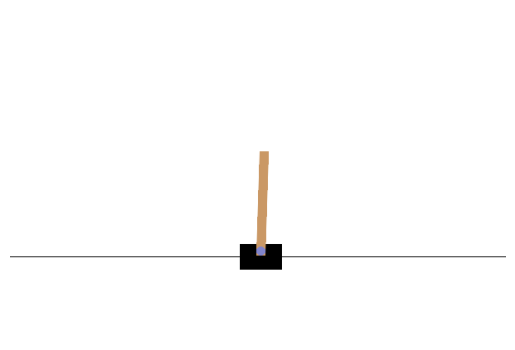

MovieWriter ffmpeg unavailable; using Pillow instead.


Animação salva em agent_performance(CartPole-v1).gif


In [9]:
# Visualização de performance:
visualize_agent(agent, env_id=game, num_episodes=1, max_steps=500, save=True, save_path=f"agent_performance({game}).gif")